In [265]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import torchvision

import matplotlib.pyplot as plt
import numpy as np

In [377]:
# Preprocessing the image dataset. Might need to create a new one for additional dataset. 
class EmotionDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_mapping = {}

        current_label_id = 0
        for label in os.listdir(directory):
            label_path = os.path.join(directory, label)
            if os.path.isdir(label_path):
                if label not in self.label_mapping:
                    self.label_mapping[label] = current_label_id
                    current_label_id += 1

                for img in os.listdir(label_path):
                    img_path = os.path.join(label_path, img)
                    self.images.append(img_path)
                    self.labels.append(self.label_mapping[label])
        # print("Label mapping:", self.label_mapping)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)
        return image, label

In [360]:
# Create dataloaders for train, val and test
data_path = os.path.join(os.getcwd(), 'archive')
filepath_train = os.path.join(data_path, 'train')
filepath_test = os.path.join(data_path, 'test')
# transforms = None

transforms = T.Compose([
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = EmotionDataset(filepath_train, transform=transforms)
test_dataset = EmotionDataset(filepath_test, transform=transforms)

validation_split = 0.2 
train_sample = int(len(train_dataset) * (1 - validation_split))
val_samples = len(train_dataset) - train_sample
train_dataset, val_dataset = random_split(train_dataset, [train_sample, val_samples], generator=torch.Generator().manual_seed(21))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

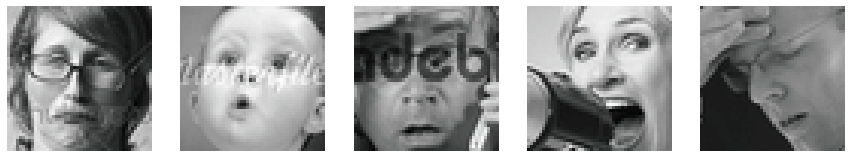

In [361]:
# display some traning samples
def imshow(img):  
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)  
    return img
    
    
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(15, 3))  
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1) 
    img = imshow(images[i])
    ax.imshow(img)
    ax.axis('off')  
plt.show()

In [269]:
# Random Model for demo
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1/10, Loss: 1.6811, Train Acc: 32.39%, Val Acc: 39.85%
Epoch 2/10, Loss: 1.4491, Train Acc: 43.65%, Val Acc: 43.36%
Epoch 3/10, Loss: 1.3263, Train Acc: 49.36%, Val Acc: 49.43%
Epoch 4/10, Loss: 1.2385, Train Acc: 52.85%, Val Acc: 50.12%
Epoch 5/10, Loss: 1.1643, Train Acc: 55.76%, Val Acc: 51.04%
Epoch 6/10, Loss: 1.0971, Train Acc: 58.83%, Val Acc: 52.72%
Epoch 7/10, Loss: 1.0338, Train Acc: 61.11%, Val Acc: 52.91%
Epoch 8/10, Loss: 0.9768, Train Acc: 63.34%, Val Acc: 53.03%
Epoch 9/10, Loss: 0.9193, Train Acc: 65.37%, Val Acc: 52.86%
Epoch 10/10, Loss: 0.8576, Train Acc: 67.98%, Val Acc: 52.61%
Training completed. Best Validation Accuracy: 53.03%


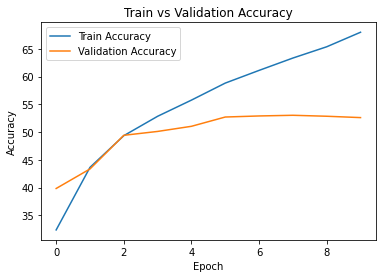

In [270]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()

train_acc = []
val_acc= []

num_epoch = 10
best_val_accuracy = 0

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        # print("Image batch shape:", images.shape)
        # print("Label batch shape:", labels.shape)
        # print("Sample labels:", labels[:5])
        optimizer.zero_grad()
        output = model(images)
        if torch.isnan(output).any():
            raise ValueError("NaN values detected in forward pass!")
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)
    # scheduler.step()

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = torch.argmax(output, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_acc.append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {running_loss/len(train_dataloader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model_state_dict.pth')

print("Training completed. Best Validation Accuracy: {:.2f}%".format(best_val_accuracy))

# Plotting train and Validation accuracies
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

In [271]:
model = CNN()
model.load_state_dict(torch.load('best_model_state_dict.pth'))

model.eval()
model.to(device)
errors = []

correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        # mismatches = predicted != labels
        # if any(mismatches):
        #     errors.append((images[mismatches], labels[mismatches], predicted[mismatches]))
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
# for imgs, lbls, preds in errors[:5]:  
#     print("True Labels:", lbls)
#     print("Predicted Labels:", preds)
#     imshow(torchvision.utils.make_grid(imgs.cpu()))

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 53.36%


The accuracy is not good. Now, we need to re-examinize the data. Furthermore, we need to implement data augmentation, regularization and fine tuning the model parameters and complexity. 

In [272]:
# The normalization method for ImageNet may not be suitable. Normalizing the dataset according to its own mean and std. 
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std

transform = T.Compose([T.Resize((48, 48)), T.ToTensor()])
train_dataset = EmotionDataset(filepath_train, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
mean, std = get_mean_std(train_loader)

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.5077, 0.5077, 0.5077])
Std: tensor([0.2550, 0.2550, 0.2550])


In [273]:
train_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(15), 
    T.ColorJitter(brightness=0.3, contrast=0.3), 
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)  
])

t_transforms = T.Compose([
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


train_dataset = EmotionDataset(filepath_train, transform=train_transforms)
val_dataset = EmotionDataset(filepath_train, transform=t_transforms) 
test_dataset = EmotionDataset(filepath_test, transform=t_transforms)

total_size = len(train_dataset)
train_size = int(total_size * (1 - validation_split))
val_size = total_size - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(123))

fer_train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
fer_val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
fer_test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [274]:
class CNN2(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 6 * 6, 256)  
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(self.pool(F.relu(self.bn3(self.conv3(x)))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

Epoch 1/200, Loss: 1.7217, Train Acc: 29.91%, Val Acc: 36.68%
Epoch 2/200, Loss: 1.5533, Train Acc: 39.58%, Val Acc: 42.51%
Epoch 3/200, Loss: 1.4847, Train Acc: 42.84%, Val Acc: 44.48%
Epoch 4/200, Loss: 1.4410, Train Acc: 44.27%, Val Acc: 45.91%
Epoch 5/200, Loss: 1.4034, Train Acc: 46.66%, Val Acc: 49.67%
Epoch 6/200, Loss: 1.3739, Train Acc: 47.70%, Val Acc: 49.15%
Epoch 7/200, Loss: 1.3559, Train Acc: 48.71%, Val Acc: 46.50%
Epoch 8/200, Loss: 1.3436, Train Acc: 48.97%, Val Acc: 49.95%
Epoch 9/200, Loss: 1.3237, Train Acc: 49.40%, Val Acc: 51.04%
Epoch 10/200, Loss: 1.3159, Train Acc: 49.98%, Val Acc: 51.93%
Epoch 11/200, Loss: 1.2978, Train Acc: 50.62%, Val Acc: 52.39%
Epoch 12/200, Loss: 1.2819, Train Acc: 51.30%, Val Acc: 51.92%
Epoch 13/200, Loss: 1.2757, Train Acc: 51.62%, Val Acc: 52.72%
Epoch 14/200, Loss: 1.2640, Train Acc: 52.14%, Val Acc: 51.27%
Epoch 15/200, Loss: 1.2554, Train Acc: 52.27%, Val Acc: 53.45%
Epoch 16/200, Loss: 1.2485, Train Acc: 52.68%, Val Acc: 53.00%
E

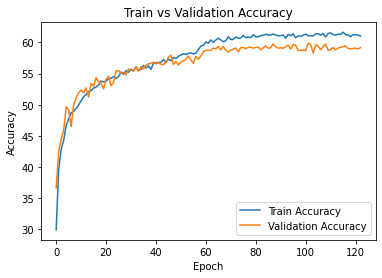

In [275]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN2()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=10, verbose=True)

loss_fn = nn.CrossEntropyLoss()

train_acc = []
val_acc= []

num_epoch = 200 # high epoch for early stopping
best_val_accuracy = 0
patience = 20 # Num of epoch of no improvement in val_acc

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in fer_train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in fer_val_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = torch.argmax(output, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_acc.append(val_accuracy)
    
    scheduler.step(val_accuracy)

    # Early stopping logic
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), 'CNN2.pth')
        early_stopping_counter = 0  
    else:
        early_stopping_counter += 1
        
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {running_loss/len(train_dataloader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
    
    if early_stopping_counter > patience:
        print("Early stopping triggered after epoch {0}".format(epoch+1))
        break

print("Training completed. Best Validation Accuracy: {:.2f}%".format(best_val_accuracy))

# Plotting train and Validation accuracies
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

In [276]:
model = CNN2()
model.load_state_dict(torch.load('CNN2.pth'))

model.eval()
model.to(device)
errors = []

correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in fer_test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 61.74%


Barely made to 60% test accuracy. The data is harder than it looks. May give ResBlock + inception a try. Before this, we can further train the model on an extended dataset. 

[ck+ dataset](https://www.kaggle.com/datasets/davilsena/ckdataset) seems too easy. 

In [277]:
import pandas as pd

In [278]:
class CKDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.data_frame = data_frame
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_pixels = self.data_frame.iloc[idx, 1]  
        image = np.fromstring(img_pixels, sep=' ').astype(np.uint8).reshape(48, 48)
        image = Image.fromarray(image).convert('L')  
        label = int(self.data_frame.iloc[idx, 0])  

        if self.transform:
            image = self.transform(image)

        return image, label

In [279]:
train_transforms =T.Compose([T.RandomHorizontalFlip(),
                             T.RandomRotation(15), 
                             T.ColorJitter(brightness=0.3, contrast=0.3),
                             T.ToTensor(),
                             T.Normalize((0.7991,), (0.5155,))])

val_transforms = T.Compose([T.ToTensor(),T.Normalize((0.7991,), (0.5155,))])
# train_transforms = T.Compose([T.ToTensor()])
# val_transforms = T.Compose([T.ToTensor()])

In [280]:
def load_datasets(csv_file):
    full_dataset = pd.read_csv(csv_file)
    train_data = full_dataset[full_dataset['Usage'] == 'Training']
    val_data = full_dataset[full_dataset['Usage'] == 'PublicTest']
    test_data = full_dataset[full_dataset['Usage'] == 'PrivateTest']

    train_dataset = CKDataset(train_data, transform=train_transforms)
    val_dataset = CKDataset(val_data, transform=val_transforms)
    test_dataset = CKDataset(test_data, transform=val_transforms)

    return train_dataset, val_dataset, test_dataset



file_path = os.path.join(os.getcwd(), 'CK')
csv_file = os.path.join(file_path, 'ckextended.csv')
train_dataset, val_dataset, test_dataset = load_datasets(csv_file)

In [281]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [290]:
model = CNN2(num_classes=7)
model.load_state_dict(torch.load('CNN2.pth', map_location=device), strict=False)

model.conv1 = nn.Conv2d(1, 16, 3, padding=1) # ck+ only has one channel

num_features = model.fc3.in_features 
model.fc3 = nn.Linear(num_features, 8)

nn.init.xavier_uniform_(model.fc3.weight)
nn.init.zeros_(model.fc3.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

Epoch 1/200, Loss: 2.3502, Train Acc: 18.26%, Val Acc: 20.88%
Epoch 2/200, Loss: 2.1242, Train Acc: 17.98%, Val Acc: 17.58%
Epoch 3/200, Loss: 2.1222, Train Acc: 16.89%, Val Acc: 26.37%
Epoch 4/200, Loss: 2.1216, Train Acc: 20.44%, Val Acc: 24.18%
Epoch 5/200, Loss: 2.0373, Train Acc: 16.89%, Val Acc: 17.58%
Epoch 6/200, Loss: 2.0865, Train Acc: 20.16%, Val Acc: 20.88%
Epoch 7/200, Loss: 2.0000, Train Acc: 18.66%, Val Acc: 36.26%
Epoch 8/200, Loss: 1.9878, Train Acc: 19.48%, Val Acc: 17.58%
Epoch 9/200, Loss: 1.9372, Train Acc: 22.34%, Val Acc: 27.47%
Epoch 10/200, Loss: 1.8749, Train Acc: 25.07%, Val Acc: 23.08%
Epoch 11/200, Loss: 1.9080, Train Acc: 24.66%, Val Acc: 31.87%
Epoch 12/200, Loss: 1.8320, Train Acc: 26.98%, Val Acc: 25.27%
Epoch 13/200, Loss: 1.8587, Train Acc: 25.89%, Val Acc: 26.37%
Epoch 14/200, Loss: 1.8466, Train Acc: 23.43%, Val Acc: 25.27%
Epoch 15/200, Loss: 1.7281, Train Acc: 29.70%, Val Acc: 36.26%
Epoch 16/200, Loss: 1.7260, Train Acc: 30.52%, Val Acc: 36.26%
E

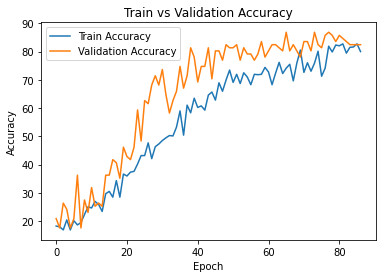

In [291]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=10, verbose=True)

class_counts = torch.tensor([45, 59, 25, 69, 28, 83, 593, 18], dtype=torch.float32)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * 8  
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))

train_acc = []
val_acc= []

num_epoch = 200 # high epoch for early stopping
best_val_accuracy = 0
patience = 20 # Num of epoch of no improvement in val_acc

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_dataloader:
        # print(images.shape)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = torch.argmax(output, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_acc.append(val_accuracy)
    
    scheduler.step(val_accuracy)

    # Early stopping logic
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), 'CNN2_updated.pth')
        early_stopping_counter = 0  
    else:
        early_stopping_counter += 1
        
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {running_loss/len(train_dataloader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
    
    if early_stopping_counter > patience:
        print("Early stopping triggered after epoch {0}".format(epoch+1))
        break

print("Training completed. Best Validation Accuracy: {:.2f}%".format(best_val_accuracy))

# Plotting train and Validation accuracies
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

In [292]:
model = CNN2(num_classes=8)
model.conv1 = nn.Conv2d(1, 16, 3, padding=1)
model.load_state_dict(torch.load('CNN2_updated.pth', map_location=device))

model.eval()
model.to(device)
errors = []

correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 85.26%


Achieved accuracy over 80% on CK+

In [298]:
model = CNN2(num_classes=8)  
model.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
model.load_state_dict(torch.load('CNN2_updated.pth', map_location=device), strict=False)

model.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
model.fc3 = nn.Linear(128, 7)  

nn.init.kaiming_normal_(model.conv1.weight, mode='fan_out', nonlinearity='relu')
if model.conv1.bias is not None:
    nn.init.constant_(model.conv1.bias, 0)
nn.init.kaiming_normal_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0)

model.to(device)
model.eval()

correct_fer = 0
total_fer = 0
with torch.no_grad():
    for images, labels in fer_test_dataloader:  
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_fer += labels.size(0)
        correct_fer += (predicted == labels).sum().item()

fer_accuracy = 100 * correct_fer / total_fer
print(f'FER Test Accuracy: {fer_accuracy:.2f}%')

FER Test Accuracy: 13.96%


The model is doing random guessing on fer. ck+ is too simple, which leads to overfitting. 

In [336]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

In [337]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels):
        super(InceptionModule, self).__init__()
        out_channels_branch = 16 
        self.branch1x1 = nn.Conv2d(in_channels, out_channels_branch, kernel_size=1)

        self.branch5x5_1 = nn.Conv2d(in_channels, out_channels_branch, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(out_channels_branch, out_channels_branch, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = nn.Conv2d(in_channels, out_channels_branch, kernel_size=1)
        self.branch3x3dbl_2 = nn.Conv2d(out_channels_branch, out_channels_branch, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = nn.Conv2d(out_channels_branch, out_channels_branch, kernel_size=3, padding=1)

        self.branch_pool = nn.Conv2d(in_channels, out_channels_branch, kernel_size=1)
        
        self.apply(init_weights)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1) 

In [338]:
class ResBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)
        
        self.apply(init_weights)

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity
        out = F.relu(out)

        return out

In [389]:
class ResInceptionNet(nn.Module):
    def __init__(self, num_classes=7):
        super(ResInceptionNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        # Residual Blocks
        self.res_block1 = ResBlock(32)  
        self.res_block2 = ResBlock(32)  
        
        # Inception module 
        self.inception = InceptionModule(32)  
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc1 = nn.Linear(64, 1024)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.inception(x)
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.drop1(F.relu(self.fc1(x)))
        x = self.drop2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [382]:
train_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.3, contrast=0.3),
    T.RandomResizedCrop(48, scale=(0.8, 1.0), ratio=(0.9, 1.1)), 
    T.RandomPerspective(distortion_scale=0.2, p=0.5),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.ToTensor(), 
    T.Normalize(mean=mean, std=std),
    T.RandomErasing(p=0.5, scale=(0.02, 0.1)) 
])


t_transforms = T.Compose([
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


train_dataset = EmotionDataset(filepath_train, transform=train_transforms)
val_dataset = EmotionDataset(filepath_train, transform=t_transforms) 
test_dataset = EmotionDataset(filepath_test, transform=t_transforms)

total_size = len(train_dataset)
train_size = int(total_size * (1 - validation_split))
val_size = total_size - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(123))

fer_train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
fer_val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
fer_test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Epoch 1/200, Loss: 1.8088, Train Acc: 24.63%, Val Acc: 24.14%
Epoch 2/200, Loss: 1.7815, Train Acc: 26.39%, Val Acc: 29.38%
Epoch 3/200, Loss: 1.7130, Train Acc: 30.53%, Val Acc: 32.06%
Epoch 4/200, Loss: 1.6388, Train Acc: 34.75%, Val Acc: 33.04%
Epoch 5/200, Loss: 1.5738, Train Acc: 37.25%, Val Acc: 37.88%
Epoch 6/200, Loss: 1.5381, Train Acc: 38.82%, Val Acc: 39.66%
Epoch 7/200, Loss: 1.5141, Train Acc: 40.45%, Val Acc: 40.07%
Epoch 8/200, Loss: 1.4928, Train Acc: 41.59%, Val Acc: 41.50%
Epoch 9/200, Loss: 1.4742, Train Acc: 42.25%, Val Acc: 36.78%
Epoch 10/200, Loss: 1.4554, Train Acc: 43.03%, Val Acc: 42.02%
Epoch 11/200, Loss: 1.4488, Train Acc: 43.61%, Val Acc: 44.79%
Epoch 12/200, Loss: 1.4307, Train Acc: 44.58%, Val Acc: 43.89%
Epoch 13/200, Loss: 1.4146, Train Acc: 44.97%, Val Acc: 45.07%
Epoch 14/200, Loss: 1.4051, Train Acc: 45.41%, Val Acc: 46.20%
Epoch 15/200, Loss: 1.3936, Train Acc: 46.03%, Val Acc: 46.85%
Epoch 16/200, Loss: 1.3745, Train Acc: 47.08%, Val Acc: 47.14%
E

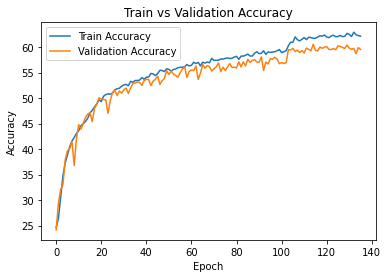

In [390]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResInceptionNet()
model.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4) 
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=10, verbose=True)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=5, mode='triangular')
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

loss_fn = nn.CrossEntropyLoss()

train_acc = []
val_acc= []

num_epoch = 200 # high epoch for early stopping
best_val_accuracy = 0
patience = 20 # Num of epoch of no improvement in val_acc

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in fer_train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in fer_val_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = torch.argmax(output, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_acc.append(val_accuracy)
    
    scheduler.step(val_accuracy)

    # Early stopping logic
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), 'ResInceptionNet.pth')
        early_stopping_counter = 0  
    else:
        early_stopping_counter += 1
        
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {running_loss/len(train_dataloader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
    
    if early_stopping_counter > patience:
        print("Early stopping triggered after epoch {0}".format(epoch+1))
        break

print("Training completed. Best Validation Accuracy: {:.2f}%".format(best_val_accuracy))

# Plotting train and Validation accuracies
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

In [391]:
model = ResInceptionNet()
model.load_state_dict(torch.load('ResInceptionNet.pth'))

model.eval()
model.to(device)
errors = []

correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in fer_test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 62.50%


I am not sure what is wrong with the model. I need to keep testing. We may want to consult our TA. Next, we need to implement the real-time emotion detection. 
The state-of-the-art accuracy is around 70-75%. 